# 12.5.4 Inspection based monitoring and finite discrete state space 

This notebook presents the scripts for the Monte Carlo Simulation and the numerical computation of the example given in section 12.5.4

Generic functions are first defined for simulation and numerical simulation, then they are used for the example of section 12.5.4.

In [1]:
import numpy as np
from numpy.linalg import matrix_power
from scipy.linalg import expm
from scipy.interpolate import interp1d

%matplotlib notebook
import matplotlib.pyplot as plt

## Generic functions for simulation and numerical computation

### Simulation

In [2]:
def RandExp(rate):
    '''Draw random samples from an exponential distribution.
    If rate is null, output is set to infinity.'''
    if rate==0:
        return np.inf
    else:
        return np.random.exponential(scale=1/rate)

In [3]:
def UpdateVar(horizonTime, currentTime, currentState, dT, nextState,
              histoTime, histoState):
    '''Update system state and time spent in the different states and achieved transitions.'''
    flagSim = True
    currentTime = currentTime+dT
    if currentTime>=horizonTime:
        flagSim = False
        dT = dT-(currentTime-horizonTime)
        currentTime = currentTime+dT
    currentState = nextState
    histoTime = np.append(histoTime, currentTime)
    histoState = np.append(histoState, currentState)
    return (flagSim, currentTime, currentState, histoTime, histoState)

In [4]:
def OneHistory(para):
    '''Simulate one history of the system until simulation time horizon is reached.
    '''
    # Intial conditions
    currentState = 3
    currentTime = 0
    flagSim = True
    # History initialization
    histoTime = np.append([], currentTime)
    histoState = np.append([], currentState)
    while flagSim:
        if (currentState==3):
            # Evaluate concurrent transitions and determine the actual one
            dT = RandExp(rate=para['lambda32'])
            nextState = 2
        elif (currentState==2):
            # Evaluate concurrent transitions and determine the actual one
            dT = RandExp(rate=para['lambda21'])
            nextState = 1
        elif (currentState==1):
            # Evaluate concurrent transitions and determine the actual one
            dT10 = RandExp(rate=para['lambda10'])
            dT13 = (np.floor(currentTime/para['inspPeriode'])+1)*para['inspPeriode']-currentTime
            dT = np.min([dT10, dT13])
            if (dT==dT13):
                nextState = 3
            elif (dT==dT10):
                nextState = 0
            else:
                raise ValueError('Approximation error')
        elif (currentState==0):
            # Evaluate concurrent transitions and determine the actual one
            dT03 = (np.floor(currentTime/para['inspPeriode'])+1)*para['inspPeriode']-currentTime
            nextState = 3
        else:
            raise ValueError('Unknown state')
        # Update variables
        (flagSim, currentTime, currentState, histoTime, histoState) = UpdateVar(
            para['horizon'], currentTime, currentState, dT, nextState, histoTime, histoState)
    return (histoTime, histoState)

In [5]:
def NHistories(nbHist, para):
    '''Simulate several histories'''
    liTime = []
    liState = []
    for iHist in range(nbHist):
        (histoTime, histoState) = OneHistory(para)
        liTime.append(histoTime)
        liState.append(histoState)
    return (liTime, liState)

### Numerical computation

In [6]:
def NumComp(nbSamp, para):
    mA = np.array([
        [np.nan, 0, 0, 0],
        [para['lambda10'], np.nan, 0, 0],
        [0, para['lambda21'], np.nan, 0],
        [0, 0, para['lambda32'], np.nan]])
    np.fill_diagonal(mA, -np.nansum(mA, axis=1))
    mB = np.array([
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 0, 0, 1]])
    vP0 = np.array([0, 0, 0, 1])
    vP = np.zeros((4, nbSamp))
    vT = np.linspace(0, para['horizon'], nbSamp)
    for j in range(len(vT)):
        i = int(np.floor(vT[j]/para['inspPeriode']))
        vP[:, j] = vP0@matrix_power(expm(para['inspPeriode']*mA)@mB, i)@expm((vT[j]-i*para['inspPeriode'])*mA)
    return (vT, vP)

## Example of section 12.5.4


### Parameters

In [7]:
# Parameters
nbHist = int(1e5)
nbSamp = 10*365

para = {
    'horizon' : 10*365*24,
    'lambda32': 3e-5,
    'lambda21': 3e-5,
    'lambda10': 3e-5,
    'inspPeriode': 365*24}
periodeNumComp = 1

### Simulations

In [8]:
# Simulation
(timeHistorySim, stateHistorySim) = NHistories(nbHist, para)

### Numerical computation 

In [9]:
# Numerical computation
(vTimeCal, mProbCal) = NumComp(nbSamp, para)

### Results

In [10]:
mProbSim = np.zeros((4, vTimeCal.shape[0]))
for kd in range(nbHist):
    fTmp = interp1d(timeHistorySim[kd], stateHistorySim[kd], kind='previous')
    vY = fTmp(vTimeCal)
    for jd in range(4):
        mProbSim[jd, :] = mProbSim[jd, :]+(vY==jd)
mProbSim = mProbSim/nbHist

<IPython.core.display.Javascript object>


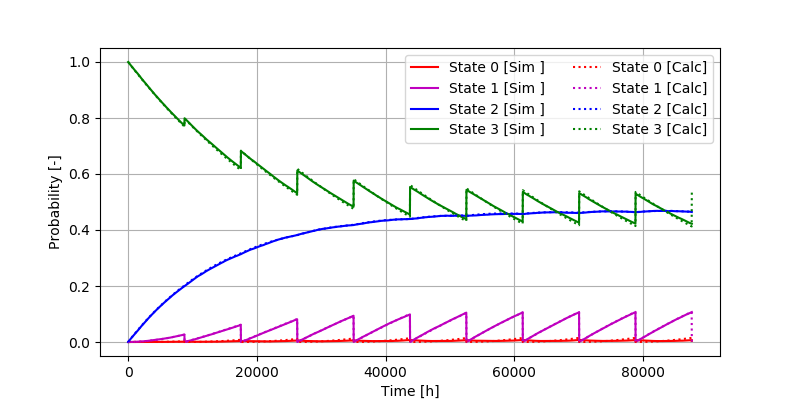

Text(0, 0.5, 'Probability [-]')

In [11]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(1, 1, 1)
vColor = ['r', 'm', 'b', 'g']
for jd in range(4):
    ax.plot(vTimeCal, mProbSim[jd, :],
            color=vColor[jd], label='State {:d} [Sim ]'.format(jd))
for jd in range(4):    
    ax.plot(vTimeCal, mProbCal[jd, :], ':',
            color=vColor[jd], label='State {:d} [Calc]'.format(jd))
ax.legend(ncol=2)
ax.grid(True)
ax.set_xlabel('Time [h]')
ax.set_ylabel('Probability [-]')